In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,  tools_condition
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv


In [2]:
os.environ["LANGSMITH_PROJECT"]="DebuggingProject"

In [3]:
load_dotenv()
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"]= "true"


In [4]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:qwen/qwen3-32b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001E3B9C173E0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001E3B9D56720>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [7]:
#Graph with tool call

@tool
def add(a:float,b:float):
    """Add two numbers"""
    return a+b

tools =[add]



llm_with_tool = llm.bind_tools([add])

def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

builder.add_conditional_edges("tool_calling_llm",
                              tools_condition)
builder.add_edge("tools","tool_calling_llm")

builder.add_edge(START,"tool_calling_llm")
builder.add_edge("tools",END)

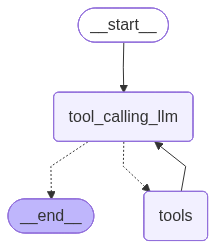

In [8]:
graph =builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
response= graph.invoke({"messages":"please add 5 and 10"})

In [32]:
response

{'messages': [HumanMessage(content='please add 5 and 10', additional_kwargs={}, response_metadata={}, id='18f4dd97-7d36-4fbf-bee7-0d84750ebe69'),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking to add 5 and 10. Let me check the tools available. There's a function called add that takes two numbers, a and b. The parameters are required, so I need to make sure both are included. The arguments should be in a JSON object. So, I'll call the add function with a=5 and b=10. That should give the correct sum.\n", 'tool_calls': [{'id': '7zzjzxqe6', 'function': {'arguments': '{"a":5,"b":10}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 116, 'prompt_tokens': 162, 'total_tokens': 278, 'completion_time': 0.201063585, 'prompt_time': 0.006881874, 'queue_time': 0.037589675, 'total_time': 0.207945459}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_78ac7f3229', 'service_tier': 'on_demand', 'finish_reas

In [10]:
response["messages"][-1].content

'The sum of 5 and 10 is **15.0**.'